In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

INTERACTIVE_SESSION = False # When submitting we can skip all the discovery and training.

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load the Disaster Tweets
Let's have a look at the train and test dataset.

They contain:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [2]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Explore the dataset

<Axes: ylabel='Frequency'>

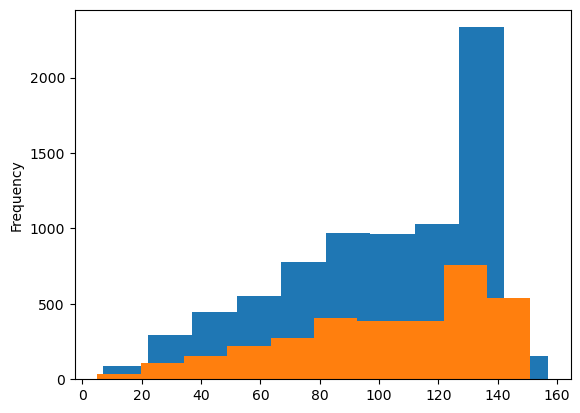

In [5]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

df_train["length"].plot.hist()
df_test["length"].plot.hist()

<Axes: ylabel='Frequency'>

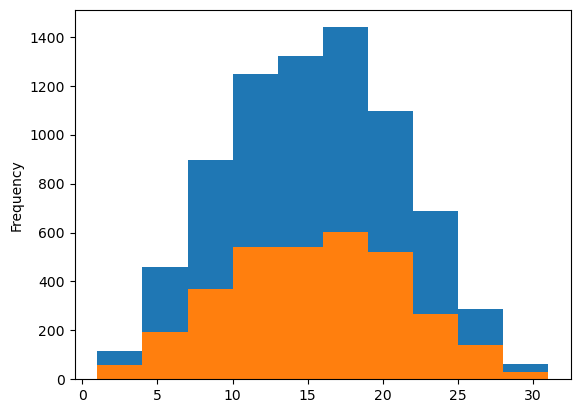

In [6]:
df_train["word_counts"] = df_train["text"].apply(lambda x : len(x.split()))
df_test["word_counts"] = df_test["text"].apply(lambda x : len(x.split()))

df_train["word_counts"].plot.hist()
df_test["word_counts"].plot.hist()

# Preprocess the data

In [7]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df_test["text"]

In [8]:
X_train

4996    Courageous and honest analysis of need to use ...
3263    @ZachZaidman @670TheScore wld b a shame if tha...
4907    Tell @BarackObama to rescind medals of 'honor'...
2855    Worried about how the CA drought might affect ...
4716    @YoungHeroesID Lava Blast &amp; Power Red #Pan...
                              ...                        
5226    @Eganator2000 There aren't many Obliteration s...
5390    just had a panic attack bc I don't have enough...
860     Omron HEM-712C Automatic Blood Pressure Monito...
7603    Officials say a quarantine is in place at an A...
7270    I moved to England five years ago today. What ...
Name: text, Length: 6090, dtype: object

In [9]:
X_test

0                      Just happened a terrible car crash
1       Heard about #earthquake is different cities, s...
2       there is a forest fire at spot pond, geese are...
3                Apocalypse lighting. #Spokane #wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260    Green Line derailment in Chicago http://t.co/U...
3261    MEG issues Hazardous Weather Outlook (HWO) htt...
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 3263, dtype: object

## Dealing with tweets

Twitter was a social media platform that focussed on short messages. We can see this in the above visalisations where there were on average 18 words in a message. This short-form introduced coloqial terms, and a more informal way of communication. More spelling mistakes, and different tone from for example wikipedia or other places on the internet. Furthermore, these tweets have url's which will not help us with identifying if the tweet is about disatsters or not.
So, dealing with these particularities, we will clean up the tweets by lowercasing them, and removing the url's. Furthermore, we will use the tweet tokenizer from nltk to treat these tweets a bit different, but you can read more about it in ther NLTK manual.

When we have finished preprocessing these tweets, we will run a basic Naive-bayes model to get an understanding of what level is a baseline, and continue to investigatre improvements

In [11]:
import re
import nltk

from nltk.tokenize import TweetTokenizer

def preprocess_tweet(text):
    """
    Clean up a tweet by lowercasing it, and removing the urls.
    """
    text = re.sub(r'https?://\S+', '', text)
    return text.lower()


def extract_features(document_tokens):
    """
    Converts a list of words to a vector
    """
    features = {}
    for word in word_features:
        features[f'contains({word})'] = (word in document_tokens)
    return features

if INTERACTIVE_SESSION:
    tknzr = TweetTokenizer()
    
    all_words_in_train = [
        word for tweet in X_train
        for word in tknzr.tokenize(preprocess_tweet(tweet))
    ]
    word_features = nltk.FreqDist(all_words_in_train).keys()
    
    train_set = [
        (extract_features(tknzr.tokenize(preprocess_tweet(tweet))), label)
        for tweet, label in zip(X_train, y_train)
    ]
    
    validation_set = [
        (extract_features(tknzr.tokenize(preprocess_tweet(tweet))), label)
        for tweet, label in zip(X_val, y_val)
    ]

## Naive bayes model for understanding

To be able to understand our data better, and to make sure there are no issues, it's always a good idea to run a very basic model, that will show you any issues, and highlight where you are falling short

In [12]:
if INTERACTIVE_SESSION:
    classifier = nltk.NaiveBayesClassifier.train(train_set)
    accuracy = nltk.classify.accuracy(classifier, validation_set)
    
    print(f"Classifier accuracy: {accuracy:.2%}")
    
    informative_features = classifier.most_informative_features(20)
    
    # Filter for words indicating 'disaster'
    disaster_words = []
    for feature, ratio in informative_features:
        # A feature is a tuple like ('contains(word)', True)
        # NaiveBayesClassifier.most_informative_features() often returns just the feature name
        if isinstance(feature, str) and classifier.classify({feature: True}) == 1:
            # Clean up the feature name to get the word
            word = feature.replace("contains(", "").replace(")", "")
            disaster_words.append((word, ratio))
    
    top_disaster_words = disaster_words[:10]
    
    words = [word for word, ratio in top_disaster_words]
    ratios = [ratio for word, ratio in top_disaster_words]
    
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    
    
    ax.barh(words, ratios, color='#d9534f')
    ax.invert_yaxis()
    
    # Add labels and title
    ax.set_xlabel('Likelihood Ratio (Disaster vs. Non-Disaster)', fontsize=12)
    ax.set_ylabel('Words', fontsize=12)
    ax.set_title(f'Top 10 Words Associated with Disaster Tweets', fontsize=14, fontweight='bold')
    
    # Add the ratio value at the end of each bar
    for index, value in enumerate(ratios):
        ax.text(value, index, f' {value:.1f}', va='center')
    
    plt.tight_layout()

## Tokenisation and embedding

We have successfully built a baseline classification model, but there are several fundamental limitations inherent in its bag-of-words approach. These issues prevent the model from capturing the full complexity of language:

1. **Loss of Sequential Context**: By treating text as an unordered collection of words, the model loses crucial information contained in word order. The position of a negation like 'no' or 'not' can completely invert a sentence's meaning, a nuance that is entirely lost.
2. **Lack of Semantic Understanding**: The model possesses no external knowledge. It learns an association between "Hiroshima" and "disaster" purely from statistical co-occurrence in the training data, without understanding the word’s real-world meaning. It also cannot recognize semantic relationships between synonyms (e.g., 'crash' and 'collision').
3. **Vocabulary and Morphological Brittleness**: The model is unable to handle words not seen during training (Out-of-Vocabulary words). Furthermore, it fails to recognize that words like "crash" and "crashed" are morphologically related and refer to the same concept, treating them as entirely separate features.

To overcome these limitations, we will transition to a more sophisticated architecture combining a Recurrent Neural Network (RNN) with pre-trained word embeddings. To address word order and context, we will use a Long Short-Term Memory (LSTM) network, which is specifically designed to process sequential data.

To solve the issues of semantic meaning, vocabulary, and morphology, we will leverage FastText embeddings. While embeddings like Word2Vec and GloVe encode rich semantic knowledge from vast text corpora, FastText offers a critical advantage: it operates on subword information (character n-grams). This allows it to generate meaningful representations for out-of-vocabulary words, handle misspellings, and understand morphological variations, making it an robust choice for analyzing dynamic and informal text like tweets.

In [13]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_fasttext_embeddings(filepath):
    embeddings_index = {}
    with open(filepath, 'r', encoding = 'utf-8', newline = '\n', errors = 'ignore') as f:
        next(f)
        for line in f:
            tokens = line.rstrip().split(' ')
            word = tokens[0]
            vec = np.array(tokens[1:], dtype = 'float32')
            embeddings_index[word] = vec
        print(f"Loaded {len(embeddings_index)} word vectors.")
        return embeddings_index

embedding_index = load_fasttext_embeddings("/kaggle/input/fasttext-wikinews/wiki-news-300d-1M.vec")

# 1. Initialize and fit the tokenizer ON THE TRAINING DATA ONLY
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# The tokenizer creates a word-to-index dictionary
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1 # +1 for the padding token
print(f"Found {len(word_index)} unique tokens.")

# 2. Convert text to sequences of integers
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

MAX_SEQUENCE_LENGTH = 32 

# Pad the sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Shape of padded training data: {X_train_padded.shape}")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Loaded 1000000 word vectors.
Found 19459 unique tokens.
Shape of padded training data: (6090, 32)


In [15]:
EMBEDDING_DIM = 300 
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    # Look up the word's vector in your loaded FastText index
    embedding_vector = embedding_index.get(word)
    
    if embedding_vector is not None:
        # Words not found in the embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(f"Shape of embedding matrix: {embedding_matrix.shape}")

Shape of embedding matrix: (19460, 300)


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.metrics import AUC

def build_model(recurrent_layer, vocab_size, embedding_dim, max_sequence_length, embedding_matrix, learning_rate=0.001):
    """
    Builds and compiles a text classification model with a specified recurrent layer.

    Args:
        recurrent_layer (tf.keras.layers.Layer): The recurrent layer to use (e.g., LSTM, GRU).
        vocab_size (int): The size of the vocabulary.
        embedding_dim (int): The dimension of the word embeddings.
        max_sequence_length (int): The input length for the sequences.
        embedding_matrix (np.ndarray): The pre-trained embedding matrix.
        learning_rate (float): The learning rate for the optimizer.

    Returns:
        tf.keras.Model: The compiled Keras model.
    """
    model = Sequential()
    
    # 1. Static Embedding Layer
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_sequence_length,
        trainable=False
    ))
    
    # 2. Dynamic Recurrent Layer (passed as an argument)
    model.add(recurrent_layer)
    
    # 3. Final Classification Layer
    model.add(Dense(1, activation='sigmoid'))
    
    # 4. Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )
    
    return model

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


def train_model(model, model_name, X_train, y_train, X_val, y_val, epochs=100, batch_size=128):
    """
    Trains a Keras model with a standard set of callbacks.

    Args:
        model (tf.keras.Model): The compiled Keras model to train.
        model_name (str): A unique name for the model, used for saving the checkpoint file.
        X_train, y_train: Training data and labels.
        X_val, y_val: Validation data and labels.
        epochs (int): The number of epochs to train for.
        batch_size (int): The size of the training batches.

    Returns:
        tf.keras.callbacks.History: The training history object.
    """
    print(f"--- Prepare data pipeline for: {model_name} ---")

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_padded, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val_padded, y_val))

    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # --- Define Callbacks ---
    
    
    callbacks = [
        EarlyStopping(monitor='val_auc', mode='max', patience=10, verbose=1, restore_best_weights=True),
        ModelCheckpoint(filepath=f'{model_name}_best.keras', save_best_only=True, monitor='val_auc', mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
    ]
    print(f"--- Starting training for model: {model_name} ---")
    # --- Run Training ---
    history = model.fit(
        train_dataset,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=val_dataset,
        callbacks=callbacks,
        verbose=1
    )

    print(f"\n--- Training complete for model: {model_name} ---")
    return history

In [18]:
import time

experiments = [
    {
        'model_name': 'lstm_64_do_02',
        'layer': LSTM(units=64, dropout=0.2),
    },
    {
        'model_name': 'gru_64_do_02',
        'layer': GRU(units=64, dropout=0.2),
    },
]

def run_experiments(experiments):
    all_histories = {}
    
    for config in experiments:
        model_name = config['model_name']
        
        print("="*50)
        print(f"🚀 STARTING EXPERIMENT: {model_name}")
        print("="*50)
    
        # Build the model using the configuration for this run
        model = build_model(
            recurrent_layer=config['layer'],
            vocab_size=vocab_size,
            embedding_dim=EMBEDDING_DIM,
            max_sequence_length=MAX_SEQUENCE_LENGTH,
            embedding_matrix=embedding_matrix
        )
        
        # Train the model and save the history
        history = train_model(
            model=model,
            model_name=model_name,
            X_train=X_train_padded,
            y_train=y_train,
            X_val=X_val_padded,
            y_val=y_val,
        )
        
        all_histories[model_name] = history
        
        print(f"✅ FINISHED EXPERIMENT: {model_name}")
        time.sleep(2) # Small pause between runs
    return all_histories

if INTERACTIVE_SESSION:
    all_histories = run_experiments(experiments)


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_auc_curves(histories):
    for model_name in histories.keys():
        df = pd.DataFrame(histories[model_name].history)
        
        # Set the style of the visualization
        sns.set_style("whitegrid")
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Plot training and validation AUC (or your primary metric)
        sns.lineplot(data=df, x=df.index, y='auc',  label='Training AUC')
        sns.lineplot(data=df, x=df.index, y='val_auc',  label='Validation AUC')
        ax.set_title(f"""AUC Over Epochs ({model_name})""")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('AUC')
        ax.legend()
        
        plt.tight_layout()
        
        file_name = f"{model_name}_auc_curves.png"
        plt.savefig(file_name)
        
        plt.show()

if INTERACTIVE_SESSION:
    plot_auc_curves(all_histories)

| Model | AUC |
| :--- | :--- |
| lstm\_64\_do\_02 | 0.840446 |
| gru\_64\_do\_02 | 0.836507 |

We can notice the GRU trained a lot faster, and even thgough it had less units scored comparitively.
Let's continue tuning this archiutecture firther:

In [21]:
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.regularizers import l2

experiments = [
    # --- Experiment 1: Baseline GRU ---
    # A medium-sized GRU with moderate dropout. Our starting point.
    {
        'model_name': 'gru_64_units_do_0.2',
        'layer': GRU(units=64, dropout=0.2, recurrent_dropout=0.2),
        'learning_rate': 1e-3
    },

    # --- Experiment 2: Test Capacity ---
    # A larger GRU to see if more model capacity helps.
    {
        'model_name': 'gru_128_units_do_0.2',
        'layer': GRU(units=128, dropout=0.2, recurrent_dropout=0.2),
        'learning_rate': 1e-3
    },
    
    # --- Experiment 3: Test Higher Dropout ---
    # Check if the model is overfitting and needs stronger regularization.
    {
        'model_name': 'gru_64_units_do_0.4',
        'layer': GRU(units=64, dropout=0.4, recurrent_dropout=0.4),
        'learning_rate': 1e-3
    },

    # --- Experiment 4: Test L2 Regularization ---
    # An alternative to dropout for controlling overfitting.
    {
        'model_name': 'gru_64_units_l2_reg',
        'layer': GRU(units=64, kernel_regularizer=l2(1e-4)),
        'learning_rate': 1e-3
    },

    # --- Experiment 5: Test ReLU Activation ---
    # See if a different activation function changes performance.
    {
        'model_name': 'gru_64_units_relu_activation',
        'layer': GRU(units=64, activation='relu', dropout=0.2, recurrent_dropout=0.2),
        'learning_rate': 1e-3
    },

    # --- Experiment 6: Compare LSTM vs. GRU ---
    # A similarly configured LSTM to see which architecture works better.
    {
        'model_name': 'lstm_64_units_do_0.2',
        'layer': LSTM(units=64, dropout=0.2, recurrent_dropout=0.2),
        'learning_rate': 1e-3
    },

    # --- Experiment 7: Test Lower Learning Rate ---
    # Check if a smaller learning rate allows for more stable training.
    {
        'model_name': 'gru_64_units_do_0.2_lr_1e-4',
        'layer': GRU(units=64, dropout=0.2, recurrent_dropout=0.2),
        'learning_rate': 1e-4
    }
]

if INTERACTIVE_SESSION:
    all_experiments = run_experiments(experiments)

| Experiment | Max Validation AUC |
| :--- | :--- |
| `gru_64_units_do_0.2` | 0.888 |
| `gru_128_units_do_0.2` | 0.886 |
| `gru_64_units_do_0.4` | 0.890 |
| `gru_64_units_l2_reg` | 0.885 |
| `gru_64_units_relu_activation` | 0.885 |
| `lstm_64_units_do_0.2` | 0.887 |
| `gru_64_units_do_0.2_lr_1e-4`| 0.888 |

In [22]:
from tensorflow.keras.models import load_model

# Define the path to your saved model file
model_path = 'gru_64_units_do_0.4_best.keras'

# Load the model into a new variable
loaded_model = load_model(model_path)

# You can optionally print the model summary to verify it loaded correctly
loaded_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 32, 300)           5838000   
                                                                 
 gru_30 (GRU)                (None, 64)                70272     
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,908,337
Trainable params: 70,337
Non-trainable params: 5,838,000
_________________________________________________________________


In [23]:
predictions_prob = loaded_model.predict(X_test_padded)
sample_submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
sample_submission["target"] = (predictions_prob > 0.5).astype(int)
sample_submission.to_csv("submission.csv", index=False)

102/102 [==============================] - 1s 7ms/step
